In [74]:
pip install --user pyLDAvis

  Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)
  Using cached pandas-2.0.1-cp39-cp39-win_amd64.whl (10.7 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Chargement des librairies nécessaires
import os, sys, time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Importer beautiful soup
from bs4 import BeautifulSoup as bs

# Remplacement de character
import re

# NLP
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import words, stopwords

#visualisation
from wordcloud import WordCloud
from PIL import Image
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.lda_model

# Gensim
import gensim

# import plotly as px
from pandarallel import pandarallel

# Import LDA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


2023-05-18 11:43:09,892 [19188] WARNING  py.warnings:109: [JupyterRequire] C:\Users\aguer\anaconda3\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu



In [83]:
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aguer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aguer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aguer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aguer\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
'''
SELECT TOP 50000 Title, Body, Tags, Id, Score, FavoriteCount, AnswerCount  
FROM Posts
WHERE PostTypeId = 1 
AND ViewCount > 10 
AND Score > 5 
AND AnswerCount > 0 
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5 
AND Id NOT IN (SELECT TOP 150000 Id FROM Posts WHERE PostTypeId = 1 AND ViewCount > 10 AND Score > 5 AND AnswerCount > 0 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5 ORDER BY Id) 
ORDER BY Id
'''

In [4]:
data = "./data/source/"
os.listdir(data)

['.ipynb_checkpoints',
 'QueryResults_1.csv',
 'QueryResults_2.csv',
 'QueryResults_3.csv',
 'QueryResults_4.csv']

In [5]:
dataset1 = data + "QueryResults_1.csv"
dataset2 = data + "QueryResults_2.csv"
dataset3 = data + "QueryResults_3.csv"
dataset4 = data + "QueryResults_4.csv"

In [6]:
# Chargement des datasets
data1 = pd.read_csv(dataset1)
data2 = pd.read_csv(dataset2)
data3 = pd.read_csv(dataset3)
data4 = pd.read_csv(dataset4)

In [7]:
# Merger les résultats
merge = [data1, data2, data3, data4]
data = pd.concat(merge, ignore_index=True)

In [8]:
# Visualisation
data.head()

,Title,Body,Tags,Id,Score,FavoriteCount,AnswerCount
0,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable &quot...,<c#><floating-point><type-conversion><double><...,4,796,0.0,14
1,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,11,1645,0.0,41
2,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,13,701,0.0,27
3,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,19,351,0.0,23
4,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,25,175,0.0,9


In [23]:
data.tail()

,Title,Body,Tags,Id,Score,FavoriteCount,AnswerCount
49995,Ionic 4 horizontal scroll with ngFor,<p>I'm at a loss. I can get horizontal scroll...,<css><angular><ionic-framework><ngfor><ionic4>,54413418,7,NaN,3
49996,Type hinting with descriptors,"<p>In <a href=""https://github.com/python/mypy/...",<python><python-3.x><type-hinting><mypy><pytho...,54413434,12,0.0,3
49997,How to add multiple lines between code blocks ...,"<p>I started using Prettier, but discovered th...",<javascript><node.js><typescript><visual-studi...,54413716,7,0.0,1
49998,React-Select Scrollbar Styling,<p>I am trying to change the style of scrollba...,<reactjs><frontend><scrollbar><styling><react-...,54413762,7,0.0,2
49999,Convert sklearn.svm SVC classifier to Keras im...,<p>I'm trying to convert some old code from us...,<machine-learning><keras><scikit-learn><neural...,54414392,19,0.0,3


In [24]:
data.sample(20)

,Title,Body,Tags,Id,Score,FavoriteCount,AnswerCount
12107,"""document is not defined"" ES6 import with Jasm...",<p>I'm having trouble working out how to set u...,<javascript><unit-testing><jasmine><ecmascript...,39691486,6,NaN,1
46437,Libgdx 3D Texture Transparency,<p>I'm having a problem with a texture which h...,<java><libgdx><textures><transparency><alphabl...,19112349,7,0.0,3
39931,R plotly hover label text alignment,<p>I'm adding custom hover text for scatterplo...,<r><hover><plotly><scatter-plot><r-plotly>,50003531,11,NaN,1
36219,Tensorflow can't detect GPU when invoked by Ra...,<p>When I try the following code sample for us...,<tensorflow><machine-learning><neural-network>...,48471716,7,NaN,1
7211,Nginx Does Not Pass Cookies To Proxy,<p>I have a cookie set will work for all subdo...,<php><ajax><apache><cookies><nginx>,22175000,29,0.0,2
9090,"Nginx RTMP Module receive x.264 , output HLS l...",<p><strong>Goal</strong>: Stream from PC using...,<nginx><stream><rtmp><live-streaming><http-liv...,38765115,8,0.0,2
4369,WebViewFragment webView is null after doing a ...,<p>I currently have my application set up with...,<android><android-3.0-honeycomb><android-webvi...,9161192,13,0.0,4
6576,Customize right click highlight on view-based ...,<p>I have a view-based NSTableView with a cust...,<objective-c><cocoa><contextmenu><nstableview>...,9619664,9,0.0,5
39322,Is there a naming convention for HTML form fie...,<p>Is there a naming convention for form field...,<html><forms><autocomplete><naming-conventions...,6365395,11,0.0,1
44022,How to play multiple sound files on one Web Pa...,<p>I have a page where there is a list of voca...,<php><javascript><jquery><audio><text-to-speech>,7198648,7,NaN,1


### Structure 

In [25]:
data.shape

(200000, 7)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          200000 non-null  object 
 1   Body           200000 non-null  object 
 2   Tags           200000 non-null  object 
 3   Id             200000 non-null  int64  
 4   Score          200000 non-null  int64  
 5   FavoriteCount  174317 non-null  float64
 6   AnswerCount    200000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 12.2+ MB


In [28]:
data.dtypes

Title             object
Body              object
Tags              object
Id                 int64
Score              int64
FavoriteCount    float64
AnswerCount        int64
dtype: object

In [29]:
data.dtypes.value_counts()

object     3
int64      3
float64    1
dtype: int64

In [30]:
data.nunique()

Title            199992
Body             200000
Tags             191464
Id               200000
Score              1118
FavoriteCount         4
AnswerCount          79
dtype: int64

On voit qu'il y a des titres de questions qui se repetent mais pas le texte meme de la question. Les id sont bien uniques.

In [31]:
tmp = data.nunique()
tmp

Title            199992
Body             200000
Tags             191464
Id               200000
Score              1118
FavoriteCount         4
AnswerCount          79
dtype: int64

In [33]:
tmp[tmp<10]

FavoriteCount    4
dtype: int64

In [34]:
tmp[tmp>1000]

Title    199992
Body     200000
Tags     191464
Id       200000
Score      1118
dtype: int64

### Nan et dupliqué

In [38]:
data.isna().sum()

Title                0
Body                 0
Tags                 0
Id                   0
Score                0
FavoriteCount    25683
AnswerCount          0
dtype: int64

In [39]:
data.isna().mean()

Title            0.000000
Body             0.000000
Tags             0.000000
Id               0.000000
Score            0.000000
FavoriteCount    0.128415
AnswerCount      0.000000
dtype: float64

Valeurs manquantes uniquement pour FavoriteCount

<AxesSubplot:>

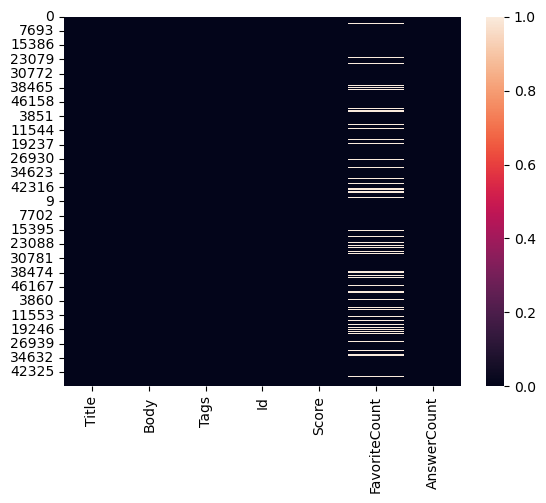

In [40]:
sns.heatmap(data.isna())

In [41]:
# Pas de lignes exactement identiques
data.duplicated().sum()

0

In [43]:
# 0 corps de questions qui sont dupliqués
data.duplicated(subset = ['Body']).sum()

0

In [45]:
for col in data.columns :
    print('col',col,'-> duplicated : ', data.duplicated(subset = [col]).sum())

col Title -> duplicated :  8
col Body -> duplicated :  0
col Tags -> duplicated :  8536
col Id -> duplicated :  0
col Score -> duplicated :  198882
col FavoriteCount -> duplicated :  199995
col AnswerCount -> duplicated :  199921


In [47]:
data.describe(include = np.number)

,Id,Score,FavoriteCount,AnswerCount
count,2.000000e+05,200000.000000,174317.000000,200000.000000
mean,2.254972e+07,27.196440,0.000281,3.475995
std,1.578556e+07,140.862624,0.079905,3.560889
min,4.000000e+00,6.000000,0.000000,1.000000
25%,8.323410e+06,7.000000,0.000000,2.000000
50%,2.008313e+07,10.000000,0.000000,3.000000
75%,3.558560e+07,19.000000,0.000000,4.000000
max,5.441439e+07,26968.000000,32.000000,133.000000


In [48]:
data.describe(include = object)

,Title,Body,Tags
count,200000,200000,200000
unique,199992,200000,191464
top,HTML Agility Pack,<p>I want to assign the decimal variable &quot...,<javascript><jquery><html><css><twitter-bootst...
freq,2,1,112


In [49]:
data.describe()

,Id,Score,FavoriteCount,AnswerCount
count,2.000000e+05,200000.000000,174317.000000,200000.000000
mean,2.254972e+07,27.196440,0.000281,3.475995
std,1.578556e+07,140.862624,0.079905,3.560889
min,4.000000e+00,6.000000,0.000000,1.000000
25%,8.323410e+06,7.000000,0.000000,2.000000
50%,2.008313e+07,10.000000,0.000000,3.000000
75%,3.558560e+07,19.000000,0.000000,4.000000
max,5.441439e+07,26968.000000,32.000000,133.000000


### Selection des colonnes 

In [139]:
cols = ['Title','Body', 'Tags']
data = data[cols]
data.head()

,Title,Body,Tags
0,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable &quot...,<c#><floating-point><type-conversion><double><...
1,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...
2,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...
3,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...
4,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>


In [140]:
data.Body[1]

'<p>Given a specific <code>DateTime</code> value, how do I display relative time, like:</p>\n<ul>\n<li><code>2 hours ago</code></li>\n<li><code>3 days ago</code></li>\n<li><code>a month ago</code></li>\n</ul>\n'

### Premier nettoyage

In [9]:
# Supprimer les balises html de notre corps de question 
data.Body = data.Body.apply(lambda x: bs(x, "lxml").text)

KeyboardInterrupt: 

In [ ]:
# Visualisation
data.Body[1]

In [ ]:
# Suppresion des retours à la ligne 
to_clean = re.compile('\n')

data.Body = data.Body.apply(lambda x: re.sub(to_clean, ' ', x))

In [ ]:
data.Body[1]

In [145]:
data.head()

,Title,Body,Tags
0,How to convert Decimal to Double in C#?,"I want to assign the decimal variable ""trans"" ...",<c#><floating-point><type-conversion><double><...
1,Calculate relative time in C#,"Given a specific DateTime value, how do I disp...",<c#><datetime><time><datediff><relative-time-s...
2,Determine a user's timezone,Is there a standard way for a web server to be...,<html><browser><timezone><user-agent><timezone...
3,What is the fastest way to get the value of π?,I'm looking for the fastest way to obtain the ...,<performance><algorithm><language-agnostic><un...
4,How to use the C socket API in C++ on z/OS,I'm having issues getting the C sockets API to...,<c++><c><sockets><mainframe><zos>


#### Duplicated

In [146]:
# Observation des données dupliquées sur la variable Title
idx = data.duplicated(subset = 'Title', keep = 'first')
data.loc[idx,:].sort_values('Title')

,Title,Body,Tags
54210,A potentially dangerous Request.Form value was...,I have this issue. I have tried everything. Va...,<c#><jquery><asp.net><architecture><postback>
30860,Git post-receive hook not working,"My setup is a windows XAMPP server, with cURL ...",<git><curl><hudson><githooks><git-post-receive>
15539,HTML Agility Pack,I want to parse the html table using html agil...,<c#><.net><winforms><html-parsing><html-agilit...
170974,Injection of autowired dependencies failed; ne...,I am new here and I am trying to create an e-s...,<java><spring><hibernate><maven><spring-mvc>
44368,LINQ to Entities does not recognize the method,I'm getting the following error when trying to...,<.net><linq><entity-framework><linq-to-entitie...
22565,Pointcut matching methods with annotated param...,I need to create an aspect with a pointcut mat...,<java><parameters><annotations><aop><aspectj>
71179,The ObjectContext instance has been disposed a...,I'm having trouble with one of my queries beca...,<entity-framework><lazy-loading><entity-framew...
73759,error LNK2019: unresolved external symbol,while i want to compile my opengl code i get t...,<c++><opengl><linker-errors><glut><glew>


In [ ]:
# Suppression des doublons sur cette variable
data.drop_duplicates(subset = 'Title', inplace = True)

#### NA

In [148]:
data.isna().mean()

Title    0.0
Body     0.0
Tags     0.0
dtype: float64

In [149]:
# Enregistrement 
data.to_csv('data/cleaned/df_cleaned.csv', index = False)

In [10]:
# Travailler sur le dataset cleané
path = 'data/cleaned/df_cleaned.csv'
df_cleaned = pd.read_csv(path)

On travaille sur de l'apprentissage supervisé dans un premier temps donc on ne travaille pas avec une target, on supprime donc les tags, que nous cherchons à prédire/proposer.

In [11]:
cols = ['Title', 'Body']
data = df_cleaned[cols]
data.head()

,Title,Body
0,How to convert Decimal to Double in C#?,"I want to assign the decimal variable ""trans"" ..."
1,Calculate relative time in C#,"Given a specific DateTime value, how do I disp..."
2,Determine a user's timezone,Is there a standard way for a web server to be...
3,What is the fastest way to get the value of π?,I'm looking for the fastest way to obtain the ...
4,How to use the C socket API in C++ on z/OS,I'm having issues getting the C sockets API to...


### EDA

#### Taille des textes

In [151]:
data.describe()

,Title,Body
count,199992,199992
unique,199992,199992
top,How to convert Decimal to Double in C#?,"I want to assign the decimal variable ""trans"" ..."
freq,1,1


2023-05-10 18:50:45,225 [13060] WARNING  py.warnings:109: [JupyterRequire] C:\Users\aguer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



<AxesSubplot:xlabel='Title'>

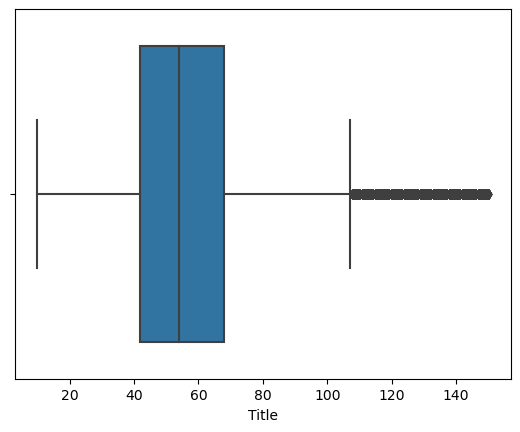

In [152]:
tmp1 = data.Title.str.len()
sns.boxplot(tmp1)

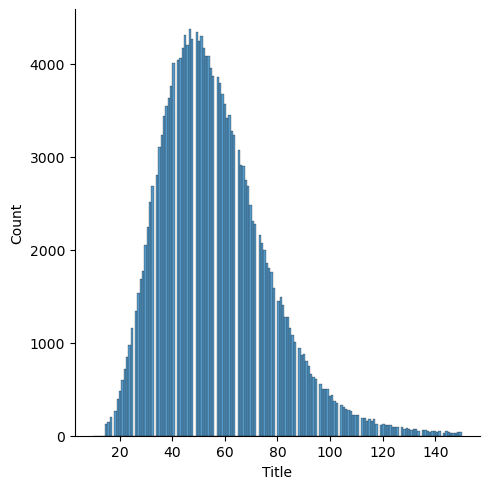

In [162]:
sns.displot(tmp1)

2023-05-10 18:50:59,806 [13060] WARNING  py.warnings:109: [JupyterRequire] C:\Users\aguer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



<AxesSubplot:xlabel='Body'>

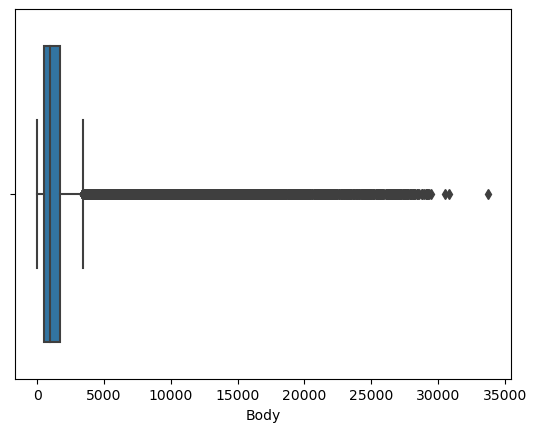

In [153]:
tmp2 = data.Body.str.len()
sns.boxplot(tmp2)

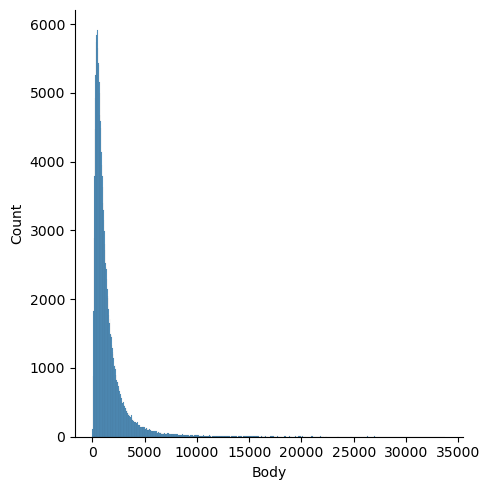

In [154]:
sns.displot(tmp2)

In [157]:
# On ajoute nos variables de taille à notre dataset 
data['_len_Title'] = tmp1
data['_len_Body'] = tmp2

In [158]:
data

,Title,Body,_len_Title,_len_Body
0,How to convert Decimal to Double in C#?,"I want to assign the decimal variable ""trans"" ...",39,250
1,Calculate relative time in C#,"Given a specific DateTime value, how do I disp...",29,108
2,Determine a user's timezone,Is there a standard way for a web server to be...,27,165
3,What is the fastest way to get the value of π?,I'm looking for the fastest way to obtain the ...,46,3052
4,How to use the C socket API in C++ on z/OS,I'm having issues getting the C sockets API to...,42,1268
...,...,...,...,...
199995,Ionic 4 horizontal scroll with ngFor,I'm at a loss. I can get horizontal scroll to...,36,1874
199996,Type hinting with descriptors,In this pull request it looks like type hintin...,29,888
199997,How to add multiple lines between code blocks ...,"I started using Prettier, but discovered that ...",60,646
199998,React-Select Scrollbar Styling,I am trying to change the style of scrollbar f...,30,390


#### Analyse multivariée

In [159]:
corr = data.corr()
corr

,_len_Title,_len_Body
_len_Title,1.000000,0.124416
_len_Body,0.124416,1.000000


On remarque que la taille du titre n'est pas vraiment liée à la taille du corps de la question

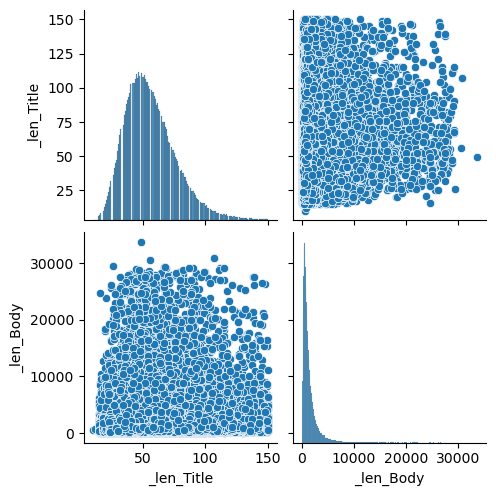

In [160]:
sns.pairplot(data)

In [163]:
data.sort_values("_len_Title").head(10)

,Title,Body,_len_Title,_len_Body
4521,TFS vs SVN,I am about to start a project (.NET) and need ...,10,526
7337,AJAXify site,I have legitimate reasons to do what I am tryi...,12,753
426,IMAP forwarder,I'm wondering what is the quickest and most re...,14,1249
782,Unrooted Tests,When running all my tests in Eclipse (Eclipse ...,14,925
49974,Screen recorder,I'm interested in a library(for windows) writt...,15,678
72213,"mov %eax,(%esp)",What is the difference between the following s...,15,217
26072,Get domain name,My computer is in a Domain (Active Directory) ...,15,953
46295,X.509 libraries,I'm looking for a library/module/package with ...,15,1008
149395,IF syntax error,I'm getting a syntax error while following the...,15,568
41438,3D in WinForms?,How can i use 3D view inside WinForms? Should ...,15,306


In [165]:
data.sort_values("_len_Title").tail(10)

,Title,Body,_len_Title,_len_Body
188225,WebSocket connection to 'ws://localhost:4000/s...,I'M using Browser Sync with webpack-dev-server...,150,3031
170013,Error message : [MC] Reading from public effec...,"When I use the following code, I have error me...",150,1810
23209,Using Encrypt=yes in a Sql Server connection s...,I'm using Encrypt=yes in a SQL Server connecti...,150,592
102398,"Why does my STS client get this error? ""The va...",I frequently encounter this error and my effor...,150,1826
99260,How to get service reference to generate corre...,I have a problem that given 3rd party WSDL I a...,150,3095
198556,Black background behind a figure's labels and ...,I have a strange problem where if I save a fig...,150,518
127845,How to redirect the user to a mobile app or a ...,I've a website which is already developed usin...,150,2909
179007,Using Jackson/Java to ensure that and all seri...,I have the following Fortify security issue: ...,150,1060
111263,java.lang.ClassCastException: com.sun.net.ssl....,I tried this code in my Netbeans 7.4 and it wo...,150,5038
140475,"""A value of type FixedToolBar cannot be added ...",We have a custom control called FixedToolBar d...,150,917


In [166]:
data.sort_values("_len_Body").head(10)

,Title,Body,_len_Title,_len_Body
3478,Are there scala-like mixins for C++?,Scala Mixins,36,13
771,"What is semantic markup, and why would I want ...",Like it says.,58,14
7181,Need to cancel click/mouseup events when doubl...,How is this done?,68,18
8653,Why the web.config isn't copied when I publish...,How to correct it?,130,19
20513,Is there a .NET data-type smaller than a byte?,How about a Nibble etc.,46,24
26470,Does myBatis implement JPA?,An easy question I suppose,27,27
1829,What is Type-safe?,"What does ""type-safe"" mean?",18,28
5764,Is there any performance difference between fo...,Or is it all about semantics?,62,30
11631,How to call a C# dll in ruby?,How to call a C# dll in ruby?,29,30
9247,What is the difference between a definition an...,The meaning of both eludes me.,62,31


In [6]:
data.sort_values("_len_Body").tail(10)

NameError: name 'data' is not defined

In [186]:
data.drop(columns = ['_len_Title', '_len_Body'], inplace = True)
data.head()

,Title,Body
0,How to convert Decimal to Double in C#?,"I want to assign the decimal variable ""trans"" ..."
1,Calculate relative time in C#,"Given a specific DateTime value, how do I disp..."
2,Determine a user's timezone,Is there a standard way for a web server to be...
3,What is the fastest way to get the value of π?,I'm looking for the fastest way to obtain the ...
4,How to use the C socket API in C++ on z/OS,I'm having issues getting the C sockets API to...


### Exploration rapide du corpus 

In [12]:
def print_sample(sub_df, n_samp = 10):
    '''print out n_samp documents from a corpus'''
    
    samp = sub_df.sample(n_samp)
    
    for idx, ser in samp.iterrows():
        txt_1 = f"title : {ser['Title']}\n"
        print(txt_1 + ser['Body'] + '\n\n')

In [190]:
print_sample(data)

title : Attach generated PDF in Mailgun message Django/Python
I'm trying to switch our application from python mail to Mailgun but am having trouble with emails that have attachments. Specifically PDF's that are generated by the application (not stored in the file system). Have no problems sending emails without attachments. Currently we generate the PDF as such: pdf = StringIO() draw_pdf(pdf, params) pdf.seek(0) attachment = MIMEApplication(pdf.read()) attachment.add_header("Content-Disposition", "attachment", filename=filename) pdf.close()  And then attach and mail it as such: from django.core.mail import EmailMultiAlternatives msg = EmailMultiAlternatives(subject, text_content, from_email, to_email)  if html_content:     msg.attach_alternative(html_content, "text/html")  if attachment:     msg.attach(attachment)  msg.send()  Works great... how can we convert to a Mailgun call? I've tried various things including just passing it as file as is (unsuccessfully): requests.post(mailgun_u

In [15]:
# Definition des stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'itself', 'that', 'here', 's', 'her', 'hadn', 'your', 'into', 'mustn', 'did', "weren't", "you've", 'in', "didn't", 'haven', 'above', 'was', 'hasn', 'and', 'am', 'weren', 'their', 'if', 'been', 'until', 'only', 'on', 'when', 'yourselves', 'them', 'it', 'off', 'our', 'between', 'then', 'themselves', 'same', 'after', 'how', 'what', 'out', 'more', 'other', 'himself', 'yours', "couldn't", 'again', 'the', 'each', 'as', 'once', 'yourself', 'up', "hadn't", "should've", 'ain', 'so', 'they', "won't", 'd', "you'll", 'an', 'during', 'have', 'aren', 'while', 'through', "you'd", "needn't", 'or', 'you', 'too', 'can', "doesn't", 'these', 'don', 'his', 'some', 'from', 'we', "haven't", "that'll", 'theirs', 'doing', "don't", 'doesn', 'hers', 'having', 'own', 'has', 'by', 'my', "aren't", 'any', 'wasn', 'such', 'couldn', 'wouldn', "she's", 'i', 'were', 'shouldn', 'now', 'against', 'just', 'm', 'will', 'didn', "mustn't", 'not', 've', 'is', 'nor', "wouldn't", 'why', 'myself', 'but', 'because', 'further', 'd

#### Premier fonction de nettoyage

In [16]:
def process_text_1(doc, rejoin= False):
    '''basic fonction of text processing'''
    
    # lower (strip pour supprimer les espaces)
    doc = doc.lower().strip()
    
    # tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    raw_tokens_list = tokenizer.tokenize(doc)
    
    # stopwords
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]
    
    # si on veut renvoyer juste les tokens séparés par un espace dans une même chaîne
    if rejoin :
        return " ".join(cleaned_tokens_list)
    
    return cleaned_tokens_list

#### Travailler sur le corpus complet

In [17]:
# Joindre les lignes 
raw_corpus1 = "".join(data.Title.values)
raw_corpus2 = "".join(data.Body.values)

In [18]:
print('Taille des titres :', len(raw_corpus1))
print('Taille des corps de question: ', len(raw_corpus2))

Taille des titres : 11280744
Taille des corps de question:  296447234


In [19]:
# process the corpus 
corpus1 = process_text_1(raw_corpus1)
corpus2 = process_text_1(raw_corpus2)

In [19]:
# Définition d'une fonction d'affichage 
def display_tokens_infos(tokens) : 
    '''display info about corpus'''
    print(f'nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}')
    print(tokens[:30])

In [20]:
# Afficher le corpus
display_tokens_infos(corpus1)

nb tokens 1182630, nb tokens uniques 135843
['convert', 'decimal', 'double', 'c', 'calculate', 'relative', 'time', 'c', 'determine', 'user', 'timezonewhat', 'fastest', 'way', 'get', 'value', 'π', 'use', 'c', 'socket', 'api', 'c', 'z', 'osis', 'gettimeofday', 'guaranteed', 'microsecond', 'resolution', 'decoding', 'sql', 'cast']


In [21]:
# Afficher le corpus
display_tokens_infos(corpus2)

nb tokens 28784645, nb tokens uniques 841687
['want', 'assign', 'decimal', 'variable', 'trans', 'double', 'variable', 'opacity', 'decimal', 'trans', 'trackbar1', 'value', '5000', 'opacity', 'trans', 'build', 'app', 'gives', 'following', 'error', 'cannot', 'implicitly', 'convert', 'type', 'decimal', 'double', 'given', 'specific', 'datetime', 'value']


In [20]:
# mot unique -> pas important

tmp1 = pd.Series(corpus1).value_counts()
list_unique_words_title = tmp1[tmp1==1]

tmp2 = pd.Series(corpus2).value_counts()
list_unique_words_body = tmp2[tmp2==1]

In [21]:
def process_text_vf(doc 
                  ,rejoin = False
                  ,lemm_or_stem = 'stem' 
                  ,list_rare_words = []
                  ,min_len_word = 3
                  ,force_is_alpha = True
                   ):
    '''
    
    positionnal arguments : 
    -----------------------
    doc : str : the docuemnt (aka a text in str format) to process
    
    opt args : 
    -----------------------
    rejoin : bool if True return a string else return a list of tokens
    lemm_or_stem : string : if lem do lemmantize else stemmentize
    list_rare_words : list : a list of rare words to exclude
    
# J'ai utilisé ça mais je ne sais pas si dans le cas de certains caracteres il faudrait enlever cette condition(C, π...)
    min_len_word : int : the minimum length of word to not exclude
    force_is_alpha : int : if 1, exclude all tokens with a numeric character

    
    return :
    -----------------------
    a string (if rejoin is True) or a list of tokens
    '''
    
        
    #lower
    doc = doc.lower().strip()
    
    # tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    raw_tokens_list = tokenizer.tokenize(doc)
    
    # classic stop words
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]
    
    # no rare tokens
    non_rare_tokens = [w for w in cleaned_tokens_list if w not in list_rare_words]
    
    # no more len words
    more_than_N = [w for w in non_rare_tokens if len(w)>= min_len_word]
    
    # only alpha chars
    if force_is_alpha :
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else :
        alpha_tokens = more_than_N
    
    # stem or lem
    if lemm_or_stem == 'lem' :
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(i) for i in alpha_tokens]
    else :
        trans = PorterStemmer()
        trans_text = [trans.stem(i) for i in alpha_tokens]
        
 
    
    # manage return type
    if rejoin :
        return ' '.join(trans_text)
    
    return trans_text

In [24]:
# Tester sur les titres
corpus1 = process_text_vf(raw_corpus1, rejoin = False)
display_tokens_infos(corpus1)

nb tokens 1096928, nb tokens uniques 112857
['convert', 'decim', 'doubl', 'calcul', 'rel', 'time', 'determin', 'user', 'timezonewhat', 'fastest', 'way', 'get', 'valu', 'use', 'socket', 'api', 'osi', 'gettimeofday', 'guarante', 'microsecond', 'resolut', 'decod', 'sql', 'cast', 'nethow', 'export', 'data', 'sql', 'server', 'mysqlhow']


In [25]:
# Tester sur les corps de question (~10 min)
corpus2 = process_text_vf(raw_corpus2, rejoin = False)
display_tokens_infos(corpus2)

nb tokens 23823423, nb tokens uniques 425630
['want', 'assign', 'decim', 'variabl', 'tran', 'doubl', 'variabl', 'opac', 'decim', 'tran', 'valu', 'opac', 'tran', 'build', 'app', 'give', 'follow', 'error', 'cannot', 'implicitli', 'convert', 'type', 'decim', 'doubl', 'given', 'specif', 'datetim', 'valu', 'display', 'rel']


2023-05-16 17:34:34,837 [21664] WARNING  py.warnings:109: [JupyterRequire] C:\Users\aguer\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else

2023-05-16 17:34:34,933 [21664] WARNING  py.warnings:109: [JupyterRequire] C:\Users\aguer\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else

2023-05-16 17:34:34,949 [21664] WARNING  py.warnings:109: [JupyterRequire] C:\Users\aguer\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else

2023

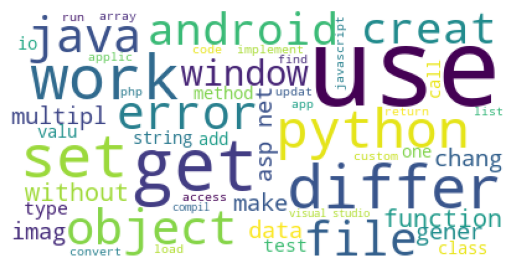

In [26]:
wordcloud = WordCloud(background_color = 'white', stopwords= [], max_words = 75).generate(' '.join(corpus1))
plt.imshow(wordcloud)
plt.axis('off')
plt.show() ;

2023-05-16 17:41:48,225 [21664] WARNING  py.warnings:109: [JupyterRequire] C:\Users\aguer\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else

2023-05-16 17:41:48,450 [21664] WARNING  py.warnings:109: [JupyterRequire] C:\Users\aguer\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else

2023-05-16 17:41:48,538 [21664] WARNING  py.warnings:109: [JupyterRequire] C:\Users\aguer\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else

2023

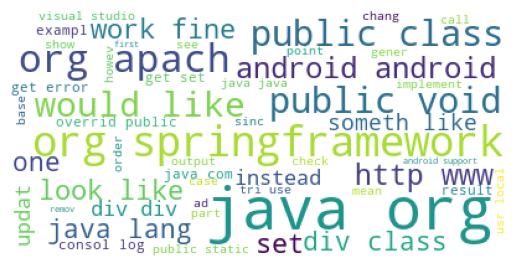

In [27]:
wordcloud = WordCloud(background_color = 'white', stopwords= [], max_words = 75).generate(' '.join(corpus2))
plt.imshow(wordcloud)
plt.axis('off')
plt.show() ;

In [28]:
pd.Series(corpus1).value_counts().head(15)

use         22360
file         8790
get          6365
error        5683
net          5630
data         5132
android      4759
java         4651
object       4649
function     4475
work         4415
python       4301
string       4131
type         4129
app          4081
Name: count, dtype: int64

In [29]:
pd.Series(corpus2).value_counts().head(15)

use       294111
java      150785
class     148837
file      145210
get       141739
new       129069
code      125329
tri       119194
error     117931
work      116661
return    114180
like      113377
name      111797
string    109735
public    109678
Name: count, dtype: int64

### LDA

Pour appliquer nos modèles de machine learning, il est indispensable de transformer nos données textuelles en données numériques

In [13]:
import time

In [22]:
start_time = time.time()

title = data.Title.apply(lambda x : process_text_vf(x, list_rare_words = list_unique_words_title,  rejoin = True))

end_time = time.time()

interval = end_time - start_time

print(f"Intervalle de temps : {interval} secondes")

Intervalle de temps : 32.39595007896423 secondes


In [27]:
# Lemmatization
start_time = time.time()

title_lem = data.Title.apply(lambda x : process_text_vf(x, lemm_or_stem ='lem', list_rare_words = list_unique_words_title, rejoin = True))

end_time = time.time()

interval = end_time - start_time

print(f"Intervalle de temps : {interval} secondes")

Intervalle de temps : 38.35848879814148 secondes


In [26]:
# Corps des questions 
start_time = time.time()

body = data.Body.apply(lambda x : process_text_vf(x, list_rare_words = list_unique_words_body, rejoin = True))

end_time = time.time()

interval = end_time - start_time

print(f"Intervalle de temps : {interval} secondes")

Intervalle de temps : 634.8622496128082 secondes


In [28]:
# Stemmatization 
start_time = time.time()

body_lem = data.Body.apply(lambda x : process_text_vf(x, lemm_or_stem ='lem', list_rare_words = list_unique_words_body, rejoin = True))

end_time = time.time()

interval = end_time - start_time

print(f"Intervalle de temps : {interval} secondes")

Intervalle de temps : 191.40502214431763 secondes


In [31]:
df = pd.DataFrame()

In [33]:
df['title_stem'] = title
df['title_lem'] = title_lem
df['body_stem'] = body
df['body_lem'] = body_lem

In [35]:
# Enregistrer en csv
df.to_csv('data/cleaned/df_tokenize.csv', index = False)

#### Utilisation de gensim 

In [134]:
import gensim 
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import pyLDAvis.gensim

In [152]:
id2word = corpora.Dictionary([corpus1])

In [153]:
new_corpus = []
for text in [corpus1] :
    new = id2word.doc2bow(text)
    new_corpus.append(new)
    
print(new_corpus[0][0:20])

[(0, 2), (1, 1), (2, 1), (3, 3), (4, 24), (5, 8), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 9), (13, 1), (14, 57), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]


In [179]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = new_corpus, 
                                            id2word= id2word, 
                                            num_topics = 15, 
                                            random_state = 100, 
                                            update_every = 1,
                                            chunksize = 100,
                                            passes = 10, 
                                            alpha = 'auto')

2023-05-18 11:24:07,685 [21664] WARNING  gensim.models.ldamodel:149: [JupyterRequire] updated prior is not positive
2023-05-18 11:24:08,833 [21664] WARNING  gensim.models.ldamodel:149: [JupyterRequire] updated prior is not positive
2023-05-18 11:24:10,001 [21664] WARNING  gensim.models.ldamodel:149: [JupyterRequire] updated prior is not positive
2023-05-18 11:24:11,124 [21664] WARNING  gensim.models.ldamodel:149: [JupyterRequire] updated prior is not positive
2023-05-18 11:24:12,256 [21664] WARNING  gensim.models.ldamodel:149: [JupyterRequire] updated prior is not positive
2023-05-18 11:24:13,425 [21664] WARNING  gensim.models.ldamodel:149: [JupyterRequire] updated prior is not positive


In [180]:
# Viz
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, new_corpus, id2word, mds = "mmds", R = 30)

In [181]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster          Freq
topic                                                   
6      0.391976 -0.022212       1        1  9.999996e+01
9     -0.045483  0.005711       2        1  3.869515e-06
14    -0.045794  0.005766       3        1  3.867892e-06
7     -0.046241  0.005845       4        1  3.853051e-06
11    -0.043823  0.005423       5        1  3.771135e-06
12    -0.042990  0.005278       6        1  3.685294e-06
5     -0.042280  0.005156       7        1  3.642151e-06
3     -0.040680  0.004853       8        1  3.380411e-06
4     -0.040618  0.004900       9        1  3.337769e-06
2     -0.040454  0.004841      10        1  3.301973e-06
0     -0.040151  0.004788      11        1  3.285090e-06
8     -0.032881  0.003535      12        1  2.483875e-06
10    -0.017963  0.000888      13        1  1.808039e-06
13    -0.008286 -0.000893      14        1  1.557192e-06
1      0.095667 -0.033879      15        1  9.312057e-07, topic_info=           Term          Freq         Total Category  logprob  loglift
105283      use  24205.000000  24205.000000  Default  30.0000  30.0000
34677      file   9547.000000   9547.000000  Default  29.0000  29.0000
39684       get   6900.000000   6900.000000  Default  28.0000  28.0000
31184     error   6133.000000   6133.000000  Default  27.0000  27.0000
64198       net   6099.000000   6099.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
110372     work      0.000022   4791.963945  Topic15  -6.1411  -0.7078
94412    string      0.000021   4480.661470  Topic15  -6.1925  -0.6920
48136        io      0.000018   3302.852444  Topic15  -6.3493  -0.5438
2170    android      0.000019   5169.588269  Topic15  -6.2975  -0.9401
49998      java      0.000018   5055.625442  Topic15  -6.3293  -0.9495

[1177 rows x 6 columns], token_table=        Topic      Freq     Term
term                            
194         1  1.000172   access
786         1  1.000108      add
2170        1  1.000080  android
3240        1  0.999974      api
3634        1  0.999990      app
...       ...       ...      ...
108378      1  0.999965      way
108507      1  0.999881      web
109630      1  0.999891   window
110124      1  0.999962  without
110372      1  1.000008     work

[80 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 15, 8, 12, 13, 6, 4, 5, 3, 1, 9, 11, 14, 2])

In [ ]:
# Calcul de la cohérence des sujets
coherence_model = CoherenceModel(model=lda_model, texts= [title], coherence='c_v')
coherence_score = coherence_model.get_coherence()

print("Coherence Score:", coherence_score)

Le One-Hot consite à créer un dictionnaire avec tous les mots qui apparaissent dans nos phrases nettoyées.
Ce dictionnaire est en fait un tableau où chaque colonne représente un mot et chaque ligne représente une phrase.
Si tel mot apparaît dans tel phrase, on met une valeur de 1 dans l’élément du tableau, sinon on met une valeur de 0.

In [33]:
tf_vectorizer = CountVectorizer(max_df = 0.95, min_df =2, max_features = 1000, stop_words = 'english')
tf = tf_vectorizer.fit_transform(title)

In [171]:
print(tf)

  (0, 192)	1
  (0, 227)	1
  (0, 270)	1
  (1, 113)	1
  (1, 729)	1
  (1, 894)	1
  (2, 246)	1
  (2, 947)	1
  (2, 897)	1
  (3, 337)	1
  (3, 969)	1
  (3, 951)	1
  (4, 946)	1
  (4, 821)	1
  (4, 33)	1
  (5, 745)	1
  (6, 229)	1
  (6, 835)	1
  (6, 120)	1
  (6, 581)	1
  (7, 835)	1
  (7, 323)	1
  (7, 214)	1
  (7, 798)	1
  (7, 575)	1
  :	:
  (199984, 896)	1
  (199984, 223)	1
  (199984, 697)	1
  (199985, 244)	1
  (199986, 946)	1
  (199986, 4)	2
  (199986, 435)	1
  (199986, 548)	1
  (199986, 845)	1
  (199986, 353)	1
  (199987, 780)	1
  (199987, 402)	1
  (199987, 452)	1
  (199988, 920)	1
  (199989, 571)	1
  (199989, 148)	1
  (199989, 507)	1
  (199989, 10)	1
  (199989, 90)	1
  (199990, 787)	1
  (199990, 860)	1
  (199990, 708)	1
  (199991, 192)	1
  (199991, 417)	1
  (199991, 480)	1


tf-idf est une approche bag-of-words

In [169]:
ctf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df =2, max_features = 1000, stop_words = 'english')
ctf = ctf_vectorizer.fit_transform(title)

In [170]:
print(ctf)

  (0, 970)	1.0
  (1, 59)	1.0
  (3, 956)	1.0
  (5, 270)	1.0
  (6, 956)	1.0
  (10, 954)	1.0
  (13, 115)	1.0
  (14, 39)	1.0
  (16, 356)	1.0
  (17, 305)	1.0
  (20, 199)	1.0
  (21, 926)	1.0
  (23, 270)	1.0
  (24, 377)	1.0
  (25, 831)	1.0
  (26, 226)	1.0
  (27, 954)	1.0
  (28, 259)	1.0
  (29, 721)	1.0
  (30, 902)	1.0
  (31, 496)	1.0
  (32, 411)	1.0
  (34, 227)	1.0
  (38, 842)	1.0
  (39, 972)	1.0
  :	:
  (23823374, 412)	1.0
  (23823380, 920)	1.0
  (23823382, 558)	1.0
  (23823383, 425)	1.0
  (23823386, 486)	1.0
  (23823387, 425)	1.0
  (23823389, 558)	1.0
  (23823391, 558)	1.0
  (23823392, 13)	1.0
  (23823394, 8)	1.0
  (23823396, 558)	1.0
  (23823397, 13)	1.0
  (23823399, 8)	1.0
  (23823401, 558)	1.0
  (23823402, 174)	1.0
  (23823404, 602)	1.0
  (23823408, 558)	1.0
  (23823409, 351)	1.0
  (23823410, 897)	1.0
  (23823411, 204)	1.0
  (23823412, 539)	1.0
  (23823414, 647)	1.0
  (23823415, 402)	1.0
  (23823417, 25)	1.0
  (23823422, 893)	1.0


In [107]:
# Title Count Vectorizer
n_topics = 20

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5,
        evaluate_every = -1,
        learning_method='online', 
        random_state=0,
        n_jobs = -1)

# Fitter sur les données
lda.fit(tf)

array([[0.0125    , 0.0125    , 0.0125    , ..., 0.0125    , 0.0125    ,
        0.0125    ],
       [0.0125    , 0.0125    , 0.0125    , ..., 0.0125    , 0.0125    ,
        0.0125    ],
       [0.0125    , 0.0125    , 0.0125    , ..., 0.0125    , 0.0125    ,
        0.5125    ],
       ...,
       [0.00833333, 0.00833333, 0.00833333, ..., 0.175     , 0.175     ,
        0.00833333],
       [0.0125    , 0.0125    , 0.0125    , ..., 0.0125    , 0.0125    ,
        0.0125    ],
       [0.2625    , 0.0125    , 0.2625    , ..., 0.0125    , 0.0125    ,
        0.0125    ]])

In [108]:
print(lda)

LatentDirichletAllocation(learning_method='online', max_iter=5, n_components=20,
                          n_jobs=-1, random_state=0)


In [123]:
from sklearn.feature_extraction.text import CountVectorizer

from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

In [130]:
# Conversion du modèle scikit-learn en un modèle Gensim
corpus_gensim = Sparse2Corpus(tf.T)
id2word = {v: k for k, v in tf_vectorizer.vocabulary_.items()}
dictionary = Dictionary.from_corpus(corpus_gensim, id2word=id2word)

# Calcul de la cohérence des sujets
coherence_model = CoherenceModel(model=lda, texts=[title], dictionary=dictionary, coherence='u_mass')
#coherence_score = coherence_model.get_coherence()

print("Coherence Score:", coherence_score)

ValueError: This topic model is not currently supported. Supported topic models should implement the `get_topics` method.

In [115]:
# Title TF-IDF
n_topics = 20

# Créer le modèle LDA
lda2 = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5,
        evaluate_every = -1,
        learning_method='online', 
        random_state=0,
        n_jobs = -1)

# Fitter sur les données
lda2.fit(ctf)

array([[0.01843675, 0.01843675, 0.01843675, ..., 0.01843675, 0.01843675,
        0.01843675],
       [0.01843128, 0.01843128, 0.01843128, ..., 0.01843128, 0.01843128,
        0.01843128],
       [0.01841896, 0.01841896, 0.6500398 , ..., 0.01841896, 0.01841896,
        0.01841896],
       ...,
       [0.0155007 , 0.0155007 , 0.27643532, ..., 0.0155007 , 0.30276567,
        0.0155007 ],
       [0.01831996, 0.01831996, 0.01831996, ..., 0.01831996, 0.01831996,
        0.21579655],
       [0.27020394, 0.01841239, 0.21174087, ..., 0.01841239, 0.01841239,
        0.01841239]])

In [116]:
# Conversion du modèle scikit-learn en un modèle Gensim
corpus_test = gensim.matutils.Sparse2Corpus(tf, documents_columns=False)
id2word = {v: k for k, v in tf_vectorizer.vocabulary_.items()}

# Calcul de la cohérence des sujets
coherence_model = CoherenceModel(model=lda_model, texts=title, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print("Coherence Score:", coherence_score)

Log Likelihood:  -3334000.5401229146
Perplexity:  5012.383524115593


In [ ]:
-6016350.7131386995
-3334000.5401229146

Perplexity:  1016.082481136487
Perplexity:  5012.383524115593

In [110]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_vectorizer.get_feature_names(), no_top_words)

2023-05-17 13:32:53,376 [21664] WARNING  py.warnings:109: [JupyterRequire] C:\Users\aguer\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Topic 0:
wrapper border npm key databas observ implement xsd deploy larg
Topic 1:
cross support studio multipl video static caus command request nil
Topic 2:
altern function tri count wait tab ident past eclips notic
Topic 3:
file rais rest utf localhost identifi cloud expect init cpp
Topic 4:
anyth theme warn myapp short high unabl standard simpli websit
Topic 5:
answer know appear usernam recommend fine rotat complet snippet sent
Topic 6:
note old idea logger inlin approach val stop press usag
Topic 7:
channel alway contact click level reader persist assert state orm
Topic 8:
appreci exampl associ textview datetim articl loader catch choos mac
Topic 9:
comput tell depend stream extern const display vector applic game
Topic 10:
termin latest load free consol sum environ router item behavior
Topic 11:
rubi auth obvious parent determin pattern role calcul port non
Topic 12:
user split nest recent protocol variabl xmln mail page slow
Topic 13:
util match embed publish perform sequenc cer

In [117]:
display_topics(lda2, ctf_vectorizer.get_feature_names(), no_top_words)

2023-05-17 13:52:38,065 [21664] WARNING  py.warnings:109: [JupyterRequire] C:\Users\aguer\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Topic 0:
wrapper key databas larg observ implement loader deploy draw undefin
Topic 1:
support cross comput hit multipl static caus press command request
Topic 2:
function css tri count nest actual wait ident usernam past
Topic 3:
rais mobil rest identifi utf localhost cloud expect declar boost
Topic 4:
anyth recent myapp border termin short bitmap docker consol warn
Topic 5:
upgrad tab recommend appear file complet eclips rotat snippet sent
Topic 6:
altern note rubi inlin look idea channel approach schedul stop
Topic 7:
everi contact level click load npm free auth persist occur
Topic 8:
appreci answer format associ datetim articl catch selector slow correctli
Topic 9:
old logger know pass val embed fine current stream extern
Topic 10:
word inject sum environ behavior item point avoid procedur compat
Topic 11:
shell spring parent obvious locat pattern port tabl properli choos
Topic 12:
theme user issu xmln protocol mail server card sinc posit
Topic 13:
util match php break relat script

In [111]:
pyLDAvis.lda_model.prepare(lda, tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19     0.044512 -0.029509       1        1  6.824190
12     0.044874 -0.029316       2        1  6.621176
2     -0.224422  0.153998       3        1  5.772286
6      0.044798 -0.029433       4        1  5.633859
3      0.044726 -0.029434       5        1  5.593516
15     0.044731 -0.029439       6        1  5.423989
17     0.052171 -0.039722       7        1  5.279551
5     -0.080429 -0.188965       8        1  5.139865
18    -0.314574  0.120323       9        1  5.123381
14     0.119978  0.265729      10        1  4.943962
13     0.044599 -0.029504      11        1  4.915881
1      0.119817  0.265150      12        1  4.733411
10     0.015421 -0.149724      13        1  4.666618
16     0.044460 -0.029524      14        1  4.592399
7      0.044526 -0.029547      15        1  4.403533
0      0.044443 -0.029537      16        1  4.301454
9      0.044384 -0.029546      17        1  4.144711
4     -0.230276 -0.062799      18        1  4.137951
11     0.044363 -0.029558      19        1  4.060513
8      0.051898 -0.039645      20        1  3.687754, topic_info=       Term          Freq         Total Category  logprob  loglift
946    user  21696.000000  21696.000000  Default  30.0000  30.0000
342    file   9465.000000   9465.000000  Default  29.0000  29.0000
307   everi   8869.000000   8869.000000  Default  28.0000  28.0000
25   altern   7597.000000   7597.000000  Default  27.0000  27.0000
698    rais   7123.000000   7123.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
979  window    388.940147    389.865806  Topic20  -4.4115   3.2978
232     def    363.817188    364.742847  Topic20  -4.4782   3.2976
387    grid    354.853108    355.778767  Topic20  -4.5032   3.2975
726   remov    339.205425    340.131084  Topic20  -4.5483   3.2974
297  entiti    323.785384    324.711043  Topic20  -4.5948   3.2973

[641 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4        14  0.999574          accord
6         8  0.998143          achiev
7         4  0.999273          action
9        10  0.998959  activitythread
10        7  0.999585          actual
...     ...       ...             ...
991      13  0.997621             www
992      18  0.998823           xcode
994       2  0.999220            xmln
995      16  0.999469             xsd
996      18  0.997116              ye

[612 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 13, 3, 7, 4, 16, 18, 6, 19, 15, 14, 2, 11, 17, 8, 1, 10, 5, 12, 9])

In [118]:
pyLDAvis.lda_model.prepare(lda2, ctf, ctf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19     0.020331  0.069843       1        1  8.289763
2     -0.166202  0.040328       2        1  6.008136
6      0.074377 -0.065767       3        1  5.667942
5     -0.169636  0.086329       4        1  5.536204
1      0.159532 -0.101377       5        1  5.356581
4     -0.095647  0.162524       6        1  5.338066
15     0.089406  0.204935       7        1  5.189189
9     -0.076135 -0.158231       8        1  5.078198
7      0.016389 -0.062647       9        1  5.043818
14     0.114514 -0.260076      10        1  4.938692
3     -0.148464  0.014251      11        1  4.909462
17    -0.029620 -0.019396      12        1  4.610927
16    -0.097347 -0.032051      13        1  4.576017
8      0.047036 -0.119685      14        1  4.407142
0     -0.074420 -0.020964      15        1  4.235868
11     0.074103 -0.046112      16        1  4.233589
18     0.281793  0.180855      17        1  4.211498
10     0.032596  0.044307      18        1  4.205142
13     0.064000  0.111552      19        1  4.132679
12    -0.116606 -0.028618      20        1  4.031086, topic_info=         Term         Freq        Total Category  logprob  loglift
986   wrapper  2819.000000  2819.000000  Default  30.0000  30.0000
698      rais  2731.000000  2731.000000  Default  29.0000  29.0000
25     altern  2629.000000  2629.000000  Default  28.0000  28.0000
307     everi  2813.000000  2813.000000  Default  27.0000  27.0000
252       dir  2010.000000  2010.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
754      rule   181.307495   182.261812  Topic20  -4.4660   3.2059
614     panda   170.399469   171.353786  Topic20  -4.5280   3.2055
534    matter   168.243188   169.197505  Topic20  -4.5408   3.2055
684  protocol   865.358621  1109.558503  Topic20  -2.9030   2.9626
946      user  1133.907671  6616.718976  Topic20  -2.6327   1.4472

[699 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
3        14  0.994091          access
4        13  0.999078          accord
6        16  0.997311          achiev
7         3  0.997720          action
9         9  0.998575  activitythread
...     ...       ...             ...
990       4  0.998972           wrong
991      12  0.994945             www
992       6  0.996930           xcode
994      20  0.999048            xmln
995       9  0.998507             xsd

[696 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 3, 7, 6, 2, 5, 16, 10, 8, 15, 4, 18, 17, 9, 1, 12, 19, 11, 14, 13])

In [88]:
ctf_lem = ctf_vectorizer.fit_transform(title2)

In [120]:
# Créer le modèle LDA
lda3 = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5,
        evaluate_every = -1,
        learning_method='online', 
        random_state=0,
        n_jobs = -1)

# Fitter sur les données
lda3.fit_transform(ctf_lem)

array([[0.01840132, 0.01840132, 0.01840132, ..., 0.01840132, 0.65037486,
        0.01840132],
       [0.01843707, 0.01843707, 0.01843707, ..., 0.64969575, 0.01843707,
        0.01843707],
       [0.01842836, 0.01842836, 0.01842836, ..., 0.01842836, 0.01842836,
        0.01842836],
       ...,
       [0.01552497, 0.01552497, 0.01552497, ..., 0.01552497, 0.13926025,
        0.01552497],
       [0.02071182, 0.02071182, 0.30958007, ..., 0.02071182, 0.02071182,
        0.02071182],
       [0.01835896, 0.01835896, 0.01835896, ..., 0.01835896, 0.20090827,
        0.01835896]])

In [121]:
# On cherche à maximiser le log likehood et minimiser la perplexité

# Log Likelyhood
print("Log Likelihood: ", lda3.score(ctf_lem))

# Perplexity. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda3.perplexity(ctf_lem))

Log Likelihood:  -3148437.1656814157
Perplexity:  4619.600716259921


In [90]:
pyLDAvis.lda_model.prepare(lda3, ctf_lem, ctf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14    -0.088191  0.029951       1        1  5.754004
9     -0.044513 -0.031626       2        1  5.717445
2     -0.112154  0.060187       3        1  5.657020
12     0.092603 -0.119860       4        1  5.270866
15     0.088263  0.149277       5        1  5.209877
8     -0.060946 -0.184921       6        1  5.161368
3     -0.015662  0.045351       7        1  5.121360
19    -0.101563 -0.117287       8        1  5.081372
4     -0.100361 -0.026389       9        1  5.036875
5     -0.004793  0.038247      10        1  5.035600
16     0.220516 -0.059280      11        1  5.000951
6     -0.057520 -0.185758      12        1  4.909188
10    -0.112659  0.067698      13        1  4.891725
18    -0.048283  0.176019      14        1  4.874470
1     -0.130118  0.049331      15        1  4.835188
17     0.056767  0.113860      16        1  4.676373
13     0.124646  0.135677      17        1  4.628025
7      0.312385 -0.114628      18        1  4.463037
11     0.048470  0.143958      19        1  4.350711
0     -0.066888 -0.169807      20        1  4.324546, topic_info=               Term         Freq        Total Category  logprob  loglift
309           error  3104.000000  3104.000000  Default  30.0000  30.0000
19          android  2501.000000  2501.000000  Default  29.0000  29.0000
371        function  2255.000000  2255.000000  Default  28.0000  28.0000
694          python  3026.000000  3026.000000  Default  27.0000  27.0000
213            data  2150.000000  2150.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
819            site   205.353168   206.287730  Topic20  -4.3641   3.1363
432  initialization   203.178682   204.113244  Topic20  -4.3747   3.1363
980          window  1396.783744  1602.787973  Topic20  -2.4469   3.0033
593             non   515.047037   624.275876  Topic20  -3.4445   2.9485
694          python   281.175971  3026.666391  Topic20  -4.0498   0.7646

[700 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1        15  0.999173     access
2        20  0.997106  accessing
4         9  0.996470     action
6         1  0.994186   activity
7        18  0.999493        add
...     ...       ...        ...
989       3  0.996994      write
991       3  0.996267      wrong
992       1  0.998394    xamarin
994       1  0.998654      xcode
995      18  0.997342        xml

[739 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 10, 3, 13, 16, 9, 4, 20, 5, 6, 17, 7, 11, 19, 2, 18, 14, 8, 12, 1])

Calculer la coherence pour comparer les modèles 

In [104]:
from gensim.models import CoherenceModel

AttributeError: 'LatentDirichletAllocation' object has no attribute 'id2word'

In [ ]:
# Conversion du modèle scikit-learn en un modèle Gensim
corpus_test = gensim.matutils.Sparse2Corpus(tf, documents_columns=False)
id2word = {v: k for k, v in tf_vectorizer.vocabulary_.items()}

# Calcul de la cohérence des sujets
coherence_model = CoherenceModel(model=lda_model, texts=title, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print("Coherence Score:", coherence_score)

Body

In [91]:
start_time = time.time()

body = data.Body.apply(lambda x : process_text_vf(x, rejoin = True))

end_time = time.time()

interval = end_time - start_time

print(f"Intervalle de temps : {interval} secondes")

Intervalle de temps : 564.5217916965485 secondes


In [98]:
body.head()

0    want assign decim variabl tran doubl variabl o...
1    given specif datetim valu display rel time lik...
2    standard way web server abl determin user time...
3    look fastest way obtain valu person challeng s...
4    issu get socket api work properli although inc...
Name: Body, dtype: object

In [92]:
tf2 = tf_vectorizer.fit_transform(body)

In [93]:
ctf2 = ctf_vectorizer.fit_transform(body)

In [94]:
# Créer le modèle LDA
lda4 = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda4.fit(tf2)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=0)

In [95]:
pyLDAvis.lda_model.prepare(lda4, tf2, ctf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.144136 -0.130842       1        1  19.532446
4     -0.127937 -0.067339       2        1   7.038652
12     0.058928 -0.081630       3        1   6.625669
1      0.151844  0.199108       4        1   5.802902
5     -0.118898 -0.170241       5        1   5.793367
6      0.212031 -0.039861       6        1   5.333534
9      0.084603 -0.017791       7        1   5.105343
14     0.178432  0.051243       8        1   4.813538
13    -0.089479 -0.081420       9        1   4.643815
17     0.154860  0.059887      10        1   4.550790
0     -0.253469  0.229646      11        1   4.292024
7     -0.112508 -0.001032      12        1   3.969418
18     0.061159  0.204275      13        1   3.608393
8      0.131152  0.086440      14        1   3.109810
10    -0.183551 -0.060868      15        1   3.090589
3     -0.001821 -0.038193      16        1   3.062017
15    -0.068253 -0.046491      17        1   2.565348
19    -0.219340  0.185531      18        1   2.446901
11     0.059279 -0.064577      19        1   2.310063
2     -0.061166 -0.215845      20        1   2.305380, topic_info=         Term           Freq          Total Category  logprob  loglift
459      java  153332.000000  153332.000000  Default  30.0000  30.0000
27    android  114998.000000  114998.000000  Default  29.0000  29.0000
342      file  132616.000000  132616.000000  Default  28.0000  28.0000
605       org  108774.000000  108774.000000  Default  27.0000  27.0000
687    public  110217.000000  110217.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
39        app   22768.138893   97063.680885  Topic20  -2.7748   2.3199
247   develop    4291.018249   19705.304271  Topic20  -4.4436   2.2456
37        api    4745.026278   43341.698484  Topic20  -4.3430   1.5579
264       doc    3536.971685   10451.742859  Topic20  -4.6369   2.6864
266  document    3901.065646   31250.014280  Topic20  -4.5389   1.6892

[875 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.729974   abl
0         2  0.046470   abl
0         3  0.013005   abl
0         5  0.031187   abl
0         6  0.028826   abl
...     ...       ...   ...
995       2  0.108630   xsd
995      11  0.891166   xsd
997       9  0.999732  year
999      13  0.095206   zip
999      15  0.904460   zip

[3197 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 5, 13, 2, 6, 7, 10, 15, 14, 18, 1, 8, 19, 9, 11, 4, 16, 20, 12, 3])

In [96]:
# Créer le modèle LDA
lda5 = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda5.fit(ctf2)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=0)

In [97]:
pyLDAvis.lda_model.prepare(lda5, ctf2, ctf_vectorizer)

2023-05-16 19:41:30,797 [21664] WARNING  py.warnings:109: [JupyterRequire] C:\Users\aguer\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.118823 -0.047344       1        1  10.948570
12     0.107518  0.033171       2        1   8.676778
6      0.145560 -0.005714       3        1   8.158617
16     0.117857 -0.052408       4        1   7.944856
9      0.115653 -0.026574       5        1   7.088337
5      0.109831 -0.059825       6        1   6.881664
8      0.129480  0.034546       7        1   6.444856
19     0.104861 -0.033456       8        1   6.425778
3      0.139316  0.012687       9        1   6.377184
7      0.092424  0.092633      10        1   6.181330
17     0.133676  0.049941      11        1   5.302126
2      0.116405 -0.016430      12        1   3.945804
11     0.071110 -0.120968      13        1   3.411845
4      0.087140  0.031791      14        1   2.979241
18    -0.234617 -0.317886      15        1   2.129990
15    -0.284598  0.109082      16        1   1.568926
13    -0.265080  0.194980      17        1   1.465173
1     -0.115840  0.188144      18        1   1.416420
0     -0.300896  0.144030      19        1   1.373437
10    -0.388625 -0.210400      20        1   1.279069, topic_info=        Term         Freq        Total Category  logprob  loglift
27   android  7968.000000  7968.000000  Default  30.0000  30.0000
420     imag  4626.000000  4626.000000  Default  29.0000  29.0000
781     self  3612.000000  3612.000000  Default  28.0000  28.0000
459     java  4105.000000  4105.000000  Default  27.0000  27.0000
963    video  2370.000000  2370.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
347   finish     0.112800   356.982564  Topic20 -11.5256  -3.7008
571     nest     0.112486   379.423148  Topic20 -11.5284  -3.7645
675   profil     0.112373   580.774015  Topic20 -11.5294  -4.1913
683  protect     0.112323   466.687226  Topic20 -11.5299  -3.9730
551    minut     0.112311   318.252995  Topic20 -11.5300  -3.5903

[915 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         1  0.027419  abstract
1         2  0.003917  abstract
1         3  0.168430  abstract
1         4  0.622798  abstract
1         5  0.035253  abstract
...     ...       ...       ...
999       7  0.028958       zip
999       8  0.542960       zip
999       9  0.072395       zip
999      10  0.057916       zip
999      13  0.101353       zip

[5957 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 13, 7, 17, 10, 6, 9, 20, 4, 8, 18, 3, 12, 5, 19, 16, 14, 2, 1, 11])

### Approche supervisé 

#### W2vec

In [36]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = df['title_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]